In [ ]:
!pip install pyspark yfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4b7de25c7ee0c86bd140fbdf3ae6d174996e2e038ba1188bf6f3658c1ae8a02f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import yfinance as yf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, when
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import mean, stddev, col, lag, when


In [ ]:
spark = SparkSession.builder \
    .appName("StockMarketPrediction") \
    .getOrCreate()


In [ ]:
COMPANY_CODES = ['TATAMOTORS.NS', 'HDFCBANK.NS', 'CIPLA.NS', 'WIPRO']

In [ ]:
# sp500 = yf.Ticker("^GSPC")
# df = sp500.history(period="max")


In [ ]:
COMPANY_CODE = "WIPRO.NS"

In [ ]:
sp500 = yf.Ticker(COMPANY_CODE)
df = sp500.history(period="max")

In [ ]:
# stock_data = yf.download('TATAMOTORS.NS', start='2002-01-01', end='2023-01-06')
# stock_data

In [ ]:
# stock_data = yf.download('HDFCBANK.NS', start='2002-01-01', end='2023-01-06')
# stock_data

In [ ]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1996-01-01 00:00:00+05:30,0.908191,0.908191,0.908191,0.908191,19999,0.0,0.0
1996-01-02 00:00:00+05:30,0.837554,0.837554,0.837554,0.837554,39999,0.0,0.0
1996-01-03 00:00:00+05:30,0.867827,0.867827,0.867827,0.867827,19999,0.0,0.0
1996-01-04 00:00:00+05:30,0.867827,0.867827,0.867827,0.867827,119999,0.0,0.0
1996-01-05 00:00:00+05:30,0.867827,0.867827,0.867827,0.867827,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-10 00:00:00+05:30,477.500000,479.450012,473.100006,477.299988,5385767,0.0,0.0
2024-04-12 00:00:00+05:30,475.000000,480.000000,470.000000,470.750000,6585023,0.0,0.0
2024-04-15 00:00:00+05:30,466.450012,468.350006,458.200012,459.350006,6088236,0.0,0.0


In [ ]:
stock_data = df.drop(columns=['Dividends', 'Stock Splits'])

In [ ]:
stock_data['Next_Close'] = stock_data['Close'].shift(-1)

In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7110 entries, 1996-01-01 00:00:00+05:30 to 2024-04-18 00:00:00+05:30
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        7110 non-null   float64
 1   High        7110 non-null   float64
 2   Low         7110 non-null   float64
 3   Close       7110 non-null   float64
 4   Volume      7110 non-null   int64  
 5   Next_Close  7109 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 388.8 KB


In [ ]:
spark_df = spark.createDataFrame(stock_data.reset_index())


In [ ]:
spark_df.show()

+-------------------+------------------+------------------+------------------+------------------+------+------------------+
|               Date|              Open|              High|               Low|             Close|Volume|        Next_Close|
+-------------------+------------------+------------------+------------------+------------------+------+------------------+
|1995-12-31 18:30:00|0.9081907272338867|0.9081907272338867|0.9081907272338867|0.9081907272338867| 19999|0.8375536203384399|
|1996-01-01 18:30:00|0.8375536203384399|0.8375536203384399|0.8375536203384399|0.8375536203384399| 39999|0.8678267598152161|
|1996-01-02 18:30:00|0.8678267598152162|0.8678267598152162|0.8678267598152162|0.8678267598152161| 19999|0.8678267598152161|
|1996-01-03 18:30:00|0.8678267598152162|0.8678267598152162|0.8678267598152162|0.8678267598152161|119999|0.8678267598152161|
|1996-01-04 18:30:00|0.8678267598152162|0.8678267598152162|0.8678267598152162|0.8678267598152161|     0|0.8678267598152161|
|1996-01

In [ ]:
spark_df.dropna()

DataFrame[Date: timestamp, Open: double, High: double, Low: double, Close: double, Volume: bigint, Next_Close: double]

In [ ]:
from pyspark.sql.functions import mean, stddev, col, lag, avg, when, sum, abs

In [ ]:
def calculate_features(data):
   # Calculate moving averages
    windowSpec20 = Window.orderBy('Date').rowsBetween(-19, 0)
    windowSpec50 = Window.orderBy('Date').rowsBetween(-49, 0)
    windowSpec200 = Window.orderBy('Date').rowsBetween(-199, 0)

    data = data.withColumn('20d_moving_avg', mean(col('Close')).over(windowSpec20))
    data = data.withColumn('50d_moving_avg', mean(col('Close')).over(windowSpec50))
    data = data.withColumn('200d_moving_avg', mean(col('Close')).over(windowSpec200))

    # Calculate daily returns
    data = data.withColumn('daily_return', (col('Close') - lag('Close', 1).over(Window.orderBy('Date'))) / lag('Close', 1).over(Window.orderBy('Date')))

    # Calculate volatility
    windowSpecVolatility = Window.orderBy('Date').rowsBetween(-19, 0)
    data = data.withColumn('volatility', stddev(col('daily_return')).over(windowSpecVolatility))

    # Calculate change, gain, loss
    data = data.withColumn('change', col('Close') - lag('Close', 1).over(Window.orderBy('Date')))
    data = data.withColumn('gain', when(col('change') > 0, col('change')).otherwise(0))
    data = data.withColumn('loss', when(col('change') < 0, -col('change')).otherwise(0))

    # Additional features
    data = data.withColumn('ema_10', avg(col('Close')).over(Window.orderBy('Date').rowsBetween(-9, 0)))
    data = data.withColumn('ema_20', avg(col('Close')).over(Window.orderBy('Date').rowsBetween(-19, 0)))
    data = data.withColumn('macd', col('ema_10') - col('ema_20'))
    data = data.withColumn('rsi', 100 - (100 / (1 + (avg(when(col('daily_return') > 0, col('daily_return'))).over(Window.orderBy('Date').rowsBetween(-13, 0)) /
                                                avg(when(col('daily_return') < 0, -col('daily_return'))).over(Window.orderBy('Date').rowsBetween(-13, 0))))))
  # Bollinger Bands
    data = data.withColumn('stddev_20', stddev(col('Close')).over(windowSpec20))
    data = data.withColumn('bollinger_upper', col('20d_moving_avg') + 2 * col('stddev_20'))
    data = data.withColumn('bollinger_lower', col('20d_moving_avg') - 2 * col('stddev_20'))

    # Average True Range (ATR)
    data = data.withColumn('tr', when(col('High') - col('Low') > abs(col('High') - lag('Close', 1).over(Window.orderBy('Date'))), col('High') - col('Low')).otherwise(when(abs(col('High') - lag('Close', 1).over(Window.orderBy('Date'))) > abs(col('Low') - lag('Close', 1).over(Window.orderBy('Date'))), abs(col('High') - lag('Close', 1).over(Window.orderBy('Date')))).otherwise(abs(col('Low') - lag('Close', 1).over(Window.orderBy('Date'))))))
    data = data.withColumn('atr', avg(col('tr')).over(windowSpec20))

    # Moving Average Convergence Divergence Signal (MACD Signal)
    data = data.withColumn('macd_signal', avg(col('macd')).over(Window.orderBy('Date').rowsBetween(-8, 0)))



    return data.dropna()


In [ ]:
# Calculate features
spark_df = calculate_features(spark_df)

In [ ]:
spark_df.show()

+-------------------+------------------+------------------+------------------+------------------+------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+
|               Date|              Open|              High|               Low|             Close|Volume|        Next_Close|    20d_moving_avg|    50d_moving_avg|   200d_moving_avg|        daily_return|          volatility|              change|                gain|                loss|            ema_10|            ema_20|                macd|               rsi|           stddev_20|   bollinger_upper|   bollinger_lower|                  tr|                 atr|         macd_signal|
+-------------------+-------

In [ ]:
spark_df.orderBy('Date', ascending=False).show(20)


+-------------------+------------------+------------------+------------------+------------------+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+
|               Date|              Open|              High|               Low|             Close|  Volume|        Next_Close|    20d_moving_avg|    50d_moving_avg|   200d_moving_avg|        daily_return|          volatility|             change|             gain|              loss|            ema_10|            ema_20|               macd|               rsi|         stddev_20|  bollinger_upper|   bollinger_lower|                tr|               atr|        macd_signal|
+-------------------+------------------+--------------

In [ ]:
# # Train-test split (for demonstration purposes, actual implementation may vary)
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=123)




In [ ]:
#del model

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def train_model(data):
    assembler = VectorAssembler(
        inputCols=['Open', 'High', 'Low', 'Close', 'Volume',
                   '20d_moving_avg', '50d_moving_avg', '200d_moving_avg',
                   'daily_return', 'volatility', 'change', 'gain', 'loss', 'ema_10', 'ema_20', 'macd', 'rsi', 'tr', 'atr', 'macd_signal'
                  ],
        outputCol='features')

    data = assembler.transform(data)

    gbt = GBTRegressor(featuresCol='features', labelCol='Next_Close', predictionCol='prediction')

    # Create a pipeline
    pipeline = Pipeline(stages=[gbt])

    #  Train the pipeline
    model = pipeline.fit(data)
    model.save("Wipro")
    # Run cross-validation, and choose the best set of parameters
    # model = rf.fit(data)


    return model





In [ ]:
# Train model
model = train_model(train_data)

In [ ]:
# from pyspark.ml import PipelineModel

# # Load the model
# model = PipelineModel.load("/content/Tatamotors")

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

def evaluate_model(model, data):
    assembler = VectorAssembler(
        inputCols=['Open', 'High', 'Low', 'Close', 'Volume',
                   '20d_moving_avg', '50d_moving_avg', '200d_moving_avg',
                   'daily_return', 'volatility', 'change', 'gain', 'loss', 'ema_10', 'ema_20', 'macd', 'rsi', 'tr', 'atr', 'macd_signal'
                  ],
        outputCol='features')

    data = assembler.transform(data)

    predictions = model.transform(data)

    # Calculate RMSE
    evaluator = RegressionEvaluator(labelCol='Next_Close', predictionCol='prediction', metricName='rmse')
    rmse = evaluator.evaluate(predictions)

    print("Root Mean Squared Error (RMSE) on Test Data:", rmse)
    return predictions



In [ ]:
# Call evaluate_model function in your main script
predictions = evaluate_model(model, test_data)

Root Mean Squared Error (RMSE) on Test Data: 8.098913951364166


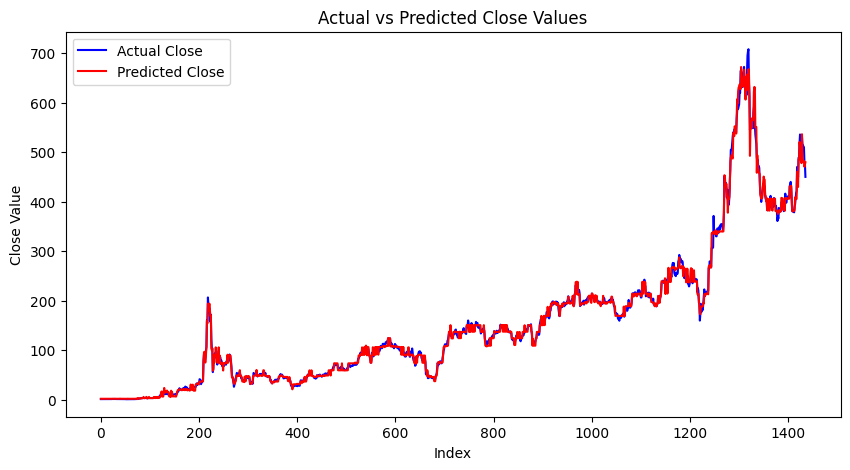

In [ ]:

import matplotlib.pyplot as plt

def plot_predictions(predictions):
    actual_close = predictions.select('Next_Close').collect()
    predicted_close = predictions.select('prediction').collect()

    actual_close_values = [row.Next_Close for row in actual_close]
    predicted_close_values = [row.prediction for row in predicted_close]

    plt.figure(figsize=(10, 5))
    plt.plot(actual_close_values, label='Actual Close', color='blue')
    plt.plot(predicted_close_values, label='Predicted Close', color='red')
    plt.xlabel('Index')
    plt.ylabel('Close Value')
    plt.title('Actual vs Predicted Close Values')
    plt.legend()
    plt.show()

# Call plot_predictions function in your main script
plot_predictions(predictions)


In [ ]:
# # end date data is excluded
# current_stock_data = yf.download(COMPANY_CODE, start='2023-01-01', end='2023-01-06')
# stock_data

In [ ]:
import datetime
import yfinance as yf

# Calculate the start and end dates
end_date = datetime.datetime.now() - datetime.timedelta(days=1)  # Yesterday
start_date = end_date - datetime.timedelta(days=200)  # Last 200 days from yesterday

print(end_date)
print(start_date)
# Convert dates to string format
end_date_str = end_date.strftime('%Y-%m-%d')
start_date_str = start_date.strftime('%Y-%m-%d')

# Download data using Yahoo Finance API
current_stock_data = yf.download(COMPANY_CODE, start=start_date_str, end=end_date_str)
# current_stock_data = stock_df(symbol='TATAMOTORS',
#                                 from_date=start_date,
#                                 to_date=end_date,
#                                 series="EQ")

current_stock_data.rename(columns=lambda x: x.title(), inplace=True)

2024-04-17 06:26:55.006333
2023-09-30 06:26:55.006333


[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Display the downloaded data
print(current_stock_data['Close'])

Date
2023-10-03    405.450012
2023-10-04    404.899994
2023-10-05    406.799988
2023-10-06    407.850006
2023-10-09    405.600006
                 ...    
2024-04-09    475.799988
2024-04-10    477.299988
2024-04-12    470.750000
2024-04-15    459.350006
2024-04-16    448.350006
Name: Close, Length: 131, dtype: float64


In [ ]:
from pyspark.sql.functions import mean, stddev, col, lag, when
from pyspark.sql import Window

def calculate_features_for_last_record(data):
    # Calculate moving averages
    windowSpec20 = Window.orderBy('Date').rowsBetween(-19, 0)
    windowSpec50 = Window.orderBy('Date').rowsBetween(-49, 0)
    windowSpec200 = Window.orderBy('Date').rowsBetween(-199, 0)

    data = data.withColumn('20d_moving_avg', mean(col('Close')).over(windowSpec20))
    data = data.withColumn('50d_moving_avg', mean(col('Close')).over(windowSpec50))
    data = data.withColumn('200d_moving_avg', mean(col('Close')).over(windowSpec200))

    # Calculate daily returns
    data = data.withColumn('daily_return', (col('Close') - lag('Close', 1).over(Window.orderBy('Date'))) / lag('Close', 1).over(Window.orderBy('Date')))

    # Calculate volatility
    windowSpecVolatility = Window.orderBy('Date').rowsBetween(-19, 0)
    data = data.withColumn('volatility', stddev(col('daily_return')).over(windowSpecVolatility))

    # Calculate change, gain, loss
    data = data.withColumn('change', col('Close') - lag('Close', 1).over(Window.orderBy('Date')))
    data = data.withColumn('gain', when(col('change') > 0, col('change')).otherwise(0))
    data = data.withColumn('loss', when(col('change') < 0, -col('change')).otherwise(0))

     # Additional features
    data = data.withColumn('ema_10', avg(col('Close')).over(Window.orderBy('Date').rowsBetween(-9, 0)))
    data = data.withColumn('ema_20', avg(col('Close')).over(Window.orderBy('Date').rowsBetween(-19, 0)))
    data = data.withColumn('macd', col('ema_10') - col('ema_20'))
    data = data.withColumn('rsi', 100 - (100 / (1 + (avg(when(col('daily_return') > 0, col('daily_return'))).over(Window.orderBy('Date').rowsBetween(-13, 0)) /
                                                avg(when(col('daily_return') < 0, -col('daily_return'))).over(Window.orderBy('Date').rowsBetween(-13, 0))))))
  # Bollinger Bands
    data = data.withColumn('stddev_20', stddev(col('Close')).over(windowSpec20))
    data = data.withColumn('bollinger_upper', col('20d_moving_avg') + 2 * col('stddev_20'))
    data = data.withColumn('bollinger_lower', col('20d_moving_avg') - 2 * col('stddev_20'))

    # Average True Range (ATR)
    data = data.withColumn('tr', when(col('High') - col('Low') > abs(col('High') - lag('Close', 1).over(Window.orderBy('Date'))), col('High') - col('Low')).otherwise(when(abs(col('High') - lag('Close', 1).over(Window.orderBy('Date'))) > abs(col('Low') - lag('Close', 1).over(Window.orderBy('Date'))), abs(col('High') - lag('Close', 1).over(Window.orderBy('Date')))).otherwise(abs(col('Low') - lag('Close', 1).over(Window.orderBy('Date'))))))
    data = data.withColumn('atr', avg(col('tr')).over(windowSpec20))

    # Moving Average Convergence Divergence Signal (MACD Signal)
    data = data.withColumn('macd_signal', avg(col('macd')).over(Window.orderBy('Date').rowsBetween(-8, 0)))



    # Select the last record and dropna
    last_record = data.orderBy(col("Date").desc()).limit(1).dropna()

    return last_record




In [ ]:
current_stock_data = spark.createDataFrame(current_stock_data.reset_index())

In [ ]:
# Assuming 'current_stock_data' is your DataFrame containing the stock data
# Replace 'current_stock_data' with your actual DataFrame
last_record_features = calculate_features_for_last_record(current_stock_data)

# Show the calculated features for the last record
last_record_features.show()

+-------------------+------------------+-----+------------------+-----------------+-----------------+--------+-----------------+-----------------+------------------+--------------------+--------------------+------+----+----+-----------------+-----------------+------------------+------------------+------------------+---------------+------------------+-----------------+------------------+-------------------+
|               Date|              Open| High|               Low|            Close|        Adj Close|  Volume|   20d_moving_avg|   50d_moving_avg|   200d_moving_avg|        daily_return|          volatility|change|gain|loss|           ema_10|           ema_20|              macd|               rsi|         stddev_20|bollinger_upper|   bollinger_lower|               tr|               atr|        macd_signal|
+-------------------+------------------+-----+------------------+-----------------+-----------------+--------+-----------------+-----------------+------------------+---------------

In [ ]:
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

# Assume 'spark' is your SparkSession

def preprocess_input_data(input_data):
    assembler = VectorAssembler(
        inputCols=['Open', 'High', 'Low', 'Close', 'Volume',
                   '20d_moving_avg', '50d_moving_avg', '200d_moving_avg',
                   'daily_return', 'volatility', 'change', 'gain', 'loss', 'ema_10', 'ema_20', 'macd', 'rsi', 'tr', 'atr', 'macd_signal'],
        outputCol='features')

    preprocessed_data = assembler.transform(input_data)

    return preprocessed_data

def predict(model, input_data):
    preprocessed_data = preprocess_input_data(input_data)

    # Make predictions
    predictions = model.transform(preprocessed_data)

    # Return predictions
    return predictions

# Assuming 'model' is your trained RandomForestRegressor model
# Assuming 'input_data' is the DataFrame containing user input data
# Replace 'model' and 'input_data' with your actual trained model and input data
input_data = [1012.25,1021.0,1010.0,1013.5, 4554077,986.8125030517579, 956.8400012207031,797.2522560062265,0.00495785820525533, 0.016751872131632543, 5.0, 5.0, 0.0 ]
predictions = predict(model, last_record_features)

# Show predictions
predictions.show()


+-------------------+------------------+-----+------------------+-----------------+-----------------+--------+-----------------+-----------------+------------------+--------------------+--------------------+------+----+----+-----------------+-----------------+------------------+------------------+------------------+---------------+------------------+-----------------+------------------+-------------------+--------------------+-----------------+
|               Date|              Open| High|               Low|            Close|        Adj Close|  Volume|   20d_moving_avg|   50d_moving_avg|   200d_moving_avg|        daily_return|          volatility|change|gain|loss|           ema_10|           ema_20|              macd|               rsi|         stddev_20|bollinger_upper|   bollinger_lower|               tr|               atr|        macd_signal|            features|       prediction|
+-------------------+------------------+-----+------------------+-----------------+-----------------+-

In [ ]:
first_prediction = predictions.select("prediction").first()[0]
print("First prediction:", first_prediction)

First prediction: 479.7681629569021


In [ ]:
!zip -r /content/Wipro.zip /content/Wipro

  adding: content/Wipro/ (stored 0%)
  adding: content/Wipro/stages/ (stored 0%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/ (stored 0%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/metadata/ (stored 0%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/metadata/._SUCCESS.crc (stored 0%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/metadata/_SUCCESS (stored 0%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/metadata/part-00000 (deflated 42%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/metadata/.part-00000.crc (stored 0%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/data/ (stored 0%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/data/._SUCCESS.crc (stored 0%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/data/part-00000-acd3bd29-e313-40a7-88c6-8b0cd09d1678-c000.snappy.parquet (deflated 11%)
  adding: content/Wipro/stages/0_GBTRegressor_7a7b0e490f35/data/_SUCCESS (store

In [ ]:
from google.colab import files
files.download("/content/Wipro.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install jugaad-data

In [ ]:
from jugaad_data.nse import NSELive
n = NSELive()
tata_motors_price = n.stock_quote('TATAMOTORS')

print(tata_motors_price)


{'info': {'symbol': 'TATAMOTORS', 'companyName': 'Tata Motors Limited', 'industry': 'AUTOMOBILES - 4 WHEELERS', 'activeSeries': ['EQ'], 'debtSeries': [], 'isFNOSec': True, 'isCASec': False, 'isSLBSec': True, 'isDebtSec': False, 'isSuspended': False, 'tempSuspendedSeries': [], 'isETFSec': False, 'isDelisted': False, 'isin': 'INE155A01022', 'isMunicipalBond': False, 'isTop10': False, 'identifier': 'TATAMOTORSEQN'}, 'metadata': {'series': 'EQ', 'symbol': 'TATAMOTORS', 'isin': 'INE155A01022', 'status': 'Listed', 'listingDate': '22-Jul-1998', 'industry': 'Passenger Cars & Utility Vehicles', 'lastUpdateTime': '15-Apr-2024 16:00:00', 'pdSectorPe': 16.88, 'pdSymbolPe': 17.6, 'pdSectorInd': 'NIFTY AUTO                                        '}, 'securityInfo': {'boardStatus': 'Main', 'tradingStatus': 'Active', 'tradingSegment': 'Normal Market', 'sessionNo': '-', 'slb': 'Yes', 'classOfShare': 'Equity', 'derivatives': 'Yes', 'surveillance': {'surv': None, 'desc': None}, 'faceValue': 2, 'issuedSiz

In [ ]:
from jugaad_data.nse import stock_df
import datetime

end_date = datetime.datetime.now() - datetime.timedelta(days=0)  # Yesterday
print(end_date)
start_date = end_date - datetime.timedelta(days=200)  # Last 200 days from yesterday


tata_motors_stock_df = stock_df(symbol='TATAMOTORS',
                                from_date=start_date,
                                to_date=end_date,
                                series="EQ")

# Make column names title case
tata_motors_stock_df.rename(columns=lambda x: x.title(), inplace=True)

tata_motors_stock_df

2024-04-15 19:24:49.631112


,Date,Series,Open,High,Low,Prev. Close,Ltp,Close,Vwap,52W H,52W L,Volume,Value,No Of Trades,Symbol
0,2024-04-15,EQ,998.10,1006.95,978.50,1018.50,997.95,998.80,996.59,1065.6,465.8,12632409,1.258937e+10,315872,TATAMOTORS
1,2024-04-12,EQ,1014.00,1029.00,1013.50,1013.50,1020.00,1018.50,1022.78,1065.6,452.0,11575194,1.183890e+10,269532,TATAMOTORS
2,2024-04-10,EQ,1012.25,1021.00,1010.00,1008.50,1014.00,1013.50,1013.34,1065.6,452.0,4554077,4.614809e+09,147535,TATAMOTORS
3,2024-04-09,EQ,1021.00,1029.50,1005.00,1013.20,1008.00,1008.50,1016.63,1065.6,452.0,8539041,8.681063e+09,165448,TATAMOTORS
4,2024-04-08,EQ,1010.05,1016.40,1004.00,1007.10,1012.70,1013.20,1011.67,1065.6,452.0,5188052,5.248589e+09,135516,TATAMOTORS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2023-10-05,EQ,619.00,621.35,614.65,613.60,619.40,619.60,618.39,665.4,375.2,7893892,4.881508e+09,224347,TATAMOTORS
131,2023-10-04,EQ,620.80,620.80,608.30,620.45,614.40,613.60,613.73,665.4,375.2,7612709,4.672182e+09,224747,TATAMOTORS
132,2023-10-03,EQ,632.60,632.65,618.60,630.20,621.10,620.45,621.92,665.4,375.2,6894577,4.287872e+09,171925,TATAMOTORS
133,2023-09-29,EQ,618.70,633.00,617.00,614.10,631.00,630.20,628.64,665.4,375.2,8969405,5.638506e+09,151844,TATAMOTORS
